In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss

# Features

In [2]:
# Load market data
es = pd.read_csv('data/spx.csv')
es.Date = pd.to_datetime(es.Date)
es.set_index('Date', inplace=True)

# Calculate 1 day returns, and roll one day after to use as prediciton
es['return'] = np.roll(es['Close'].pct_change(),-1)
es = es.loc['2012-01-04':'2020-5-29']
es.head()

,Close,return
Date,,
2012-01-04,1133.00,0.003089
2012-01-05,1136.50,-0.002200
2012-01-06,1134.00,0.001764
2012-01-09,1136.00,0.010343
2012-01-10,1147.75,0.000653


In [3]:
# Load sentiment and topic features
sentiment_features = pd.read_csv('data/sentiment_features.csv')
nmf_features = pd.read_csv('data/nmf_features.csv')

# Merge features
sentiment_features = sentiment_features.iloc[1:].reset_index(drop=True)
features = nmf_features.copy()
features.Date = pd.to_datetime(features.Date, dayfirst=True)
features.set_index('Date', inplace=True)
sentiment_features.index = features.index
features = sentiment_features.join(features).drop(['Date'],axis=1)
features.index = pd.to_datetime(features.index)
features.sort_index(inplace=True)

#features.drop(['daily_average_politics'],axis=1, inplace=True)
features.head()

,daily_average,daily_average_fintwit,daily_average_news,daily_average_politics,daily_average_trader,num_tweets,topic_coherence,topic_coherence_diff,recon_ratio
Date,,,,,,,,,
2012-01-04,-0.266243,-0.334767,-0.166645,-0.239557,-0.336303,1.0,0.744901,0.898953,0.002581
2012-01-05,-0.337371,-0.384344,-0.291280,-0.243320,-0.368697,1.0,0.644985,0.845906,0.004651
2012-01-06,-0.325877,-0.355626,-0.321614,-0.214214,-0.354338,1.0,0.729873,0.811649,0.005132
2012-01-09,-0.252546,-0.257554,-0.255376,-0.235941,-0.223905,1.0,0.670430,0.847776,0.009600
2012-01-10,-0.302168,-0.332257,-0.267115,-0.251730,-0.336150,1.0,0.686796,0.872777,0.002024


# Cross Validation

Cross validate max_depth for RandomForest and GradientBoostingClassifier  
Range of max_depth = 6-20  
Exclude low levels of max_depth to avoid the model always choosing same category  
Use ROC-AUC and logloss as measure. They yield same rankings  

In [4]:
# Cutoff for test set
date = '2018-12-31'

es_class = 1*(es['return'] >0)

X = features[:date]
y = es_class[:date]

# 5 fold time series split
# The Validation is done like this:
# TRAIN: [0] TEST: [1]
# TRAIN: [0 1] TEST: [2]
# TRAIN: [0 1 2] TEST: [3]
# TRAIN: [0 1 2 3] TEST: [4]
# TRAIN: [0 1 2 3 4] TEST: [5]

tscv= TimeSeriesSplit(n_splits=5)

logloss = pd.DataFrame(index = range(6,21), columns=['rf', 'boost'])
rocauc = pd.DataFrame(index = range(6,21), columns=['rf', 'boost'])

for max_depth in range(6,21):
    rf_logloss = []
    boost_logloss = []
    
    rf_rocauc = []
    boost_rocauc = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Random Forest Classifier
        clf = RandomForestClassifier(max_depth=max_depth, criterion='entropy', random_state=42)
        clf.fit(X_train, y_train)
        rf_logloss.append(log_loss(clf.predict(X_test), y_test))
        rf_rocauc.append(roc_auc_score(clf.predict(X_test), y_test))
        # Gradient Boosting Classifier
        clf = GradientBoostingClassifier(max_depth=max_depth, random_state=42)
        clf.fit(X_train, y_train)
        boost_logloss.append(log_loss(clf.predict(X_test), y_test))
        boost_rocauc.append(roc_auc_score(clf.predict(X_test), y_test))
        
    logloss.loc[max_depth, 'rf'] = np.mean(rf_logloss)
    logloss.loc[max_depth, 'boost'] = np.mean(boost_logloss)
    
            
    rocauc.loc[max_depth, 'rf'] = np.mean(rf_rocauc)
    rocauc.loc[max_depth, 'boost'] = np.mean(boost_rocauc)

In [5]:
# Max reached at max_depth=15 for Random Forest, max_depth=9 for Boost
logloss

,rf,boost
6,16.4358,16.8884
7,16.4596,17.0075
8,16.412,16.9837
9,16.6978,16.3644
10,16.5072,17.0552
11,16.7931,16.9837
12,16.5787,17.1266
13,17.0789,17.2696
14,16.412,17.4363
15,16.3882,17.1743


In [6]:
# Max reached at max_depth=15 for Random Forest, max_depth=9 for Boost
rocauc

,rf,boost
6,0.5072,0.496931
7,0.508627,0.492607
8,0.501226,0.491009
9,0.4941,0.513954
10,0.499638,0.490439
11,0.48585,0.498611
12,0.500237,0.489983
13,0.478843,0.488558
14,0.506507,0.48406
15,0.510174,0.492034


# Performance Analysis

In [7]:
def sharpe_ratio(pos, ret):
    # Mean of returns divided by standard deviation of returns, annualized
    return np.sqrt(252) * ( pos * ret ).mean() / ( pos * ret ).std()

In [8]:
# Two strategies: 
# One: If model predicts up move, buy S&P500 at close, if it predicts down move, flat
# Two: If model predicts up move, buy S&P500 at close, if it predicts down move, short S&P500 at close

# Sharpe for each fold for strategy One/Two
rf_sharpe = []
rf_short_sharpe = []

boost_sharpe = []
boost_short_sharpe = []

# direction * return for each day for strategy One/Two
rf_pos = []
rf_pos_short = []

boost_pos = []
boost_pos_short = []

# Up.down prediction for each day
rf_position = []
boost_position = []

# Sharpe for SPX
es_sharpe = []

# Collecting stats for each training fold for the best model found

X = features[:date]
y = es_class[:date]

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    es_sharpe.append(sharpe_ratio(1,es['return'][test_index]))
    
    clf = RandomForestClassifier(max_depth=15, criterion='entropy',random_state= 42)
    clf.fit(X_train, y_train)
    rf_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][test_index]))
    rf_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][test_index]))
    rf_pos.append(clf.predict(X_test)*es['return'][test_index])
    rf_position.append(clf.predict(X_test))
    rf_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][test_index])
    
    clf = GradientBoostingClassifier(max_depth=9,random_state= 42)
    clf.fit(X_train, y_train)
    boost_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][test_index]))
    boost_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][test_index]))
    boost_pos.append(clf.predict(X_test)*es['return'][test_index])
    boost_position.append(clf.predict(X_test))
    boost_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][test_index])

# Collecting stats for the test set for the best model found
    
X_train = features[:date]
X_test = features[date:]

y = 1*(es['return'] >0)

y_train = y[:date]
y_test = y[date:]

es_sharpe.append(sharpe_ratio(1,es['return'][date:]))

clf = RandomForestClassifier(max_depth=15, criterion='entropy',random_state= 42)
clf.fit(X_train, y_train)
rf_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][date:]))
rf_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][date:]))
rf_pos.append(clf.predict(X_test)*es['return'][date:])
rf_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][date:])
rf_position.append(clf.predict(X_test))
    
clf = GradientBoostingClassifier(max_depth=9,random_state= 42)
clf.fit(X_train, y_train)
boost_sharpe.append(sharpe_ratio(clf.predict(X_test), es['return'][date:]))
boost_short_sharpe.append(sharpe_ratio((2 * clf.predict(X_test) - 1), es['return'][date:]))
boost_pos.append(clf.predict(X_test)*es['return'][date:])
boost_pos_short.append((2 * clf.predict(X_test) - 1)*es['return'][date:])
boost_position.append(clf.predict(X_test))


rf_pos = pd.concat(rf_pos)
rf_pos_short = pd.concat(rf_pos_short)
rf_position = np.concatenate(rf_position)

boost_pos = pd.concat(boost_pos)
boost_pos_short = pd.concat(boost_pos_short)
boost_position = np.concatenate(boost_position)


In [9]:
# Stats for both strategies
# Strategy One is Long, Strategy Two is Short
# Accuracy, F1-Score, Sharpe for full period, Sharpe for Test Set, % of days with a position

Stats = pd.DataFrame(index=['SPX','RF','GradBoost'],
            columns=['Accuracy', 
                     'F1', 
                     'Sharpe Long Total', 
                     'Sharpe Short Total', 
                     'Sharpe Long Test', 
                     'Sharpe Short Test', 
                     'Days Long'])

fold_0_ind = 291

Stats.loc['SPX','Accuracy'] = accuracy_score(y.iloc[fold_0_ind:]*0 + 1, y.iloc[fold_0_ind:])
Stats.loc['RF', 'Accuracy'] = accuracy_score(rf_position, y.iloc[fold_0_ind:])
Stats.loc['GradBoost', 'Accuracy'] = accuracy_score(boost_position, y.iloc[fold_0_ind:])

Stats.loc['SPX','F1'] = ''
Stats.loc['RF', 'F1'] = f1_score(rf_position, y.iloc[fold_0_ind:])
Stats.loc['GradBoost', 'F1'] = f1_score(boost_position, y.iloc[fold_0_ind:])

Stats.loc['SPX','Sharpe Long Total'] = sharpe_ratio(1,es.iloc[fold_0_ind:]['return'])
Stats.loc['RF', 'Sharpe Long Total'] = sharpe_ratio(1,rf_pos)
Stats.loc['GradBoost', 'Sharpe Long Total'] = sharpe_ratio(1,boost_pos)


Stats.loc['SPX','Sharpe Short Total'] = sharpe_ratio(1,es.iloc[fold_0_ind:]['return'])
Stats.loc['RF', 'Sharpe Short Total'] = sharpe_ratio(1,rf_pos_short)
Stats.loc['GradBoost', 'Sharpe Short Total'] = sharpe_ratio(1,boost_pos_short)

Stats.loc['SPX','Sharpe Long Test'] = es_sharpe[-1]
Stats.loc['RF', 'Sharpe Long Test'] = rf_sharpe[-1]
Stats.loc['GradBoost', 'Sharpe Long Test'] = boost_sharpe[-1]

Stats.loc['SPX','Sharpe Short Test'] = es_sharpe[-1]
Stats.loc['RF', 'Sharpe Short Test'] = rf_short_sharpe[-1]
Stats.loc['GradBoost', 'Sharpe Short Test'] = boost_short_sharpe[-1]


Stats.loc['SPX', 'Days Long'] = 1
Stats.loc['RF', 'Days Long'] = rf_position.sum()/len(rf_position)
Stats.loc['GradBoost', 'Days Long'] = boost_position.sum()/len(boost_position)

Stats

,Accuracy,F1,Sharpe Long Total,Sharpe Short Total,Sharpe Long Test,Sharpe Short Test,Days Long
SPX,0.549085,,0.69096,0.69096,0.629522,0.629522,1
RF,0.544648,0.646882,0.809364,0.707095,1.34748,1.62605,0.740433
GradBoost,0.520244,0.600831,0.595086,0.254204,0.797615,0.561864,0.652801


Random Forest beats SPX and Gradboost in both the Long and Long/Short strategy

# Feature Importances

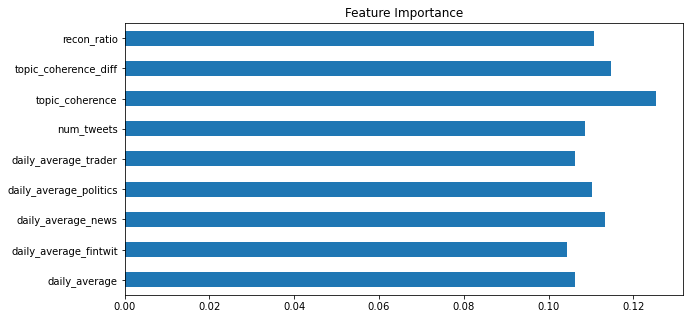

In [10]:
date = '2018-12-31'

X_train = features[:date]
X_test = features[date:]

y = 1*(es['return'] >0)

y_train = y[:date]
y_test = y[date:]

clf = RandomForestClassifier(max_depth=15, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


CCC = pd.DataFrame(columns=['feature_importances'], index = X_train.columns)
CCC['feature_importances'] = clf.feature_importances_
CCC.plot.barh(figsize=(10,5), legend=False, title="Feature Importance");


- All features seem to contribute in a similar scale 
- Topic coherence seems the most important
- Sentiment is split between different categories
